# 5. ADI forward modeling of point sources

> Authors: *Valentin Christiaens* and *Carlos Alberto Gomez Gonzalez*  
> Suitable for VIP *v1.0.0* onwards  
> Last update: *2022/09/21*

**Table of contents**

* [5.1. Loading ADI data](#1.-Loading-ADI-data)

* [5.2. Generating and injecting synthetic planets](#5.2.-Generating-and-injecting-synthetic-planets)
 
* [5.3. Flux and position estimation with NEGFC](#5.3.-Flux-and-position-estimation-with-NEGFC)
    - [5.3.1. Nelder-Mead based optimization](#5.3.1.-Nelder-Mead-based-optimization)
    - [5.3.2. Planet subtraction](#5.3.2.-Planet-subtraction)
    - [5.3.3. NEGFC technique coupled with MCMC](#5.3.3.-NEGFC-technique-coupled-with-MCMC)
        - [5.3.3.1. Running the MCMC sampler](#5.3.3.1.-Running-the-MCMC-sampler)
        - [5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots](#5.3.3.2.-Visualizing-the-MCMC-chain:-corner-plots-and-walk-plots)
        - [5.3.3.3. Highly probable values and confidence intervals](#5.3.3.3.-Highly-probable-values-and-confidence-intervals)
    - [5.3.4. Residual speckle uncertainty](#5.3.4.-Residual-speckle-uncertainty)
    - [5.3.5. Final uncertainties](#5.3.5.-Final-uncertainties)

This tutorial shows:

- how to generate and inject fake companions in a cube;
- how to estimate the astrometry and photometry of a directly imaged companion, and associated uncertainties.

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In the following box we import all the VIP routines that will be used in this tutorial.
The path to some routines has changed between versions 1.0.3 and 1.1.0, which saw a major revamp of the modular architecture, hence the `if` statements.

In [2]:
import vip_hci as vip
vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.0.0"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.0.0 or above to run this notebook."
    raise ValueError(msg)
elif version.parse(vvip) <= version.parse("1.0.3"):
    from vip_hci.conf import VLT_NACO
    from vip_hci.metrics import cube_inject_companions
    from vip_hci.negfc import (confidence, firstguess, mcmc_negfc_sampling, show_corner_plot, show_walk_plot,
                               speckle_noise_uncertainty)
    from vip_hci.pca import pca, pca_annular, pca_annulus, pca_grid
else:
    from vip_hci.config import VLT_NACO
    from vip_hci.fm import (confidence, cube_inject_companions, cube_planet_free, firstguess, mcmc_negfc_sampling, 
                            normalize_psf, show_corner_plot, show_walk_plot, speckle_noise_uncertainty)
    from vip_hci.psfsub import median_sub, pca, pca_annular, pca_annulus, pca_grid
    
# common to all versions:
from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.metrics import contrast_curve, detection, significance, snr, snrmap, throughput
from vip_hci.preproc import frame_crop
from vip_hci.var import fit_2dgaussian, frame_center

VIP version:  1.5.0


## 5.1. Loading ADI data

In the 'dataset' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO  dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract) obtained using the Annular Groove Phase Mask (AGPM) Vortex coronagraph. The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset, and on opening and visualizing fits files with VIP in general, is available in Tutorial `1. Quick start`.

Let's load the data:

In [3]:
psfnaco = '../datasets/naco_betapic_psf.fits'
cubename = '../datasets/naco_betapic_cube_cen.fits'
angname = '../datasets/naco_betapic_pa.fits'

cube = open_fits(cubename)
psf = open_fits(psfnaco)
pa = open_fits(angname)

Fits HDU-0 data successfully loaded, header available. Data shape: (61, 101, 101)
Fits HDU-0 data successfully loaded, header available. Data shape: (39, 39)
Fits HDU-0 data successfully loaded, header available. Data shape: (61,)


In [4]:
derot_off = 104.84 # NACO derotator offset for this observation (Absil et al. 2013)
TN = -0.45         # Position angle of true north for NACO at the epoch of observation (Absil et al. 2013)

angs = pa+derot_off+TN

Let's measure the FWHM by fitting a 2D Gaussian to the core of the unsaturated non-coronagraphic PSF:

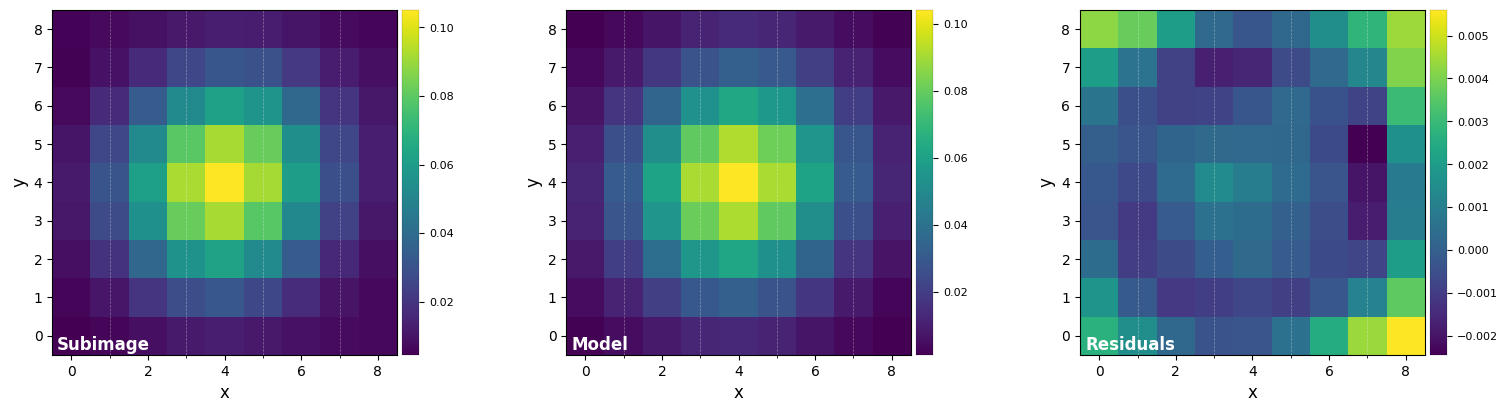

FWHM_y = 4.733218722257211
FWHM_x = 4.4736824050602895 

centroid y = 19.006680059041177
centroid x = 18.999424475165444
centroid y subim = 4.006680059041176
centroid x subim = 3.9994244751654446 

amplitude = 0.10413004853269539
theta = -34.08563676834199


In [5]:
%matplotlib inline
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)

In [6]:
fwhm_naco = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])
print(fwhm_naco)

4.60345056365875


Let's normalize the flux to one in a 1xFWHM aperture and crop the PSF array:

In [7]:
psfn = normalize_psf(psf, fwhm_naco, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 1.228


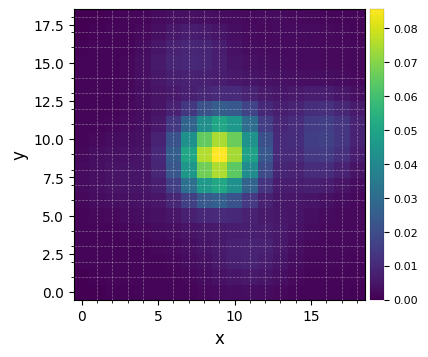

In [8]:
plot_frames(psfn, grid=True, size_factor=4)

Let's finally define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `config` subpackage:

In [9]:
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


## 5.2. Generating and injecting synthetic planets

We first select an image library `imlib` for image operations (shifts, rotations) and associated `interpolation` order. 'vip-fft' is more accurate, but 'skimage' is faster, and 'opencv' even faster - see `Tutorial 7` for more details.

In [10]:
imlib_rot = 'opencv' #'skimage'
interpolation='lanczos4' #'biquintic'   

The `cube_inject_companions` function in the `fm` module (VIP versions >= 1.1.0) makes the injection of fake companions at arbitrary fluxes and locations very easy. The normalized non-coronagraphic PSF should be provided for the injection. If the user does not have access to an observed PSF, the `create_synth_psf` from the `var` module can be used to create synthetic ones (based on 2D Gaussian, Moffat or Airy models).

Some procedures, e.g. the negative fake companion technique and the contrast curve generation, heavily rely on the injection of fake companions. The coordinates for the injection should be provided in the **derotated** image, while the actual injection occurs in the images of the input cube, i.e. in the *rotated* field.

In [11]:
rad_fc = 30.5
theta_fc = 240
flux_fc = 400.

gt = [rad_fc, theta_fc, flux_fc]

In [12]:
cubefc = cube_inject_companions(cube, psf_template=psfn, angle_list=angs, flevel=flux_fc, plsc=pxscale_naco, 
                                rad_dists=[rad_fc], theta=theta_fc, n_branches=1, 
                                imlib=imlib_rot, interpolation=interpolation)


Let's set the corresponding cartesian coordinates:

In [13]:
cy, cx = frame_center(cube[0])
x_fc = cx + rad_fc*np.cos(np.deg2rad(theta_fc))
y_fc = cy + rad_fc*np.sin(np.deg2rad(theta_fc))

xy_test = (x_fc, y_fc)
print('({:.1f}, {:.1f})'.format(xy_test[0],xy_test[1]))

(34.7, 23.6)


Let's double-check the fake companion was injected at the right location, by post-processing the cube and checking the final image. Let's use PCA, and infer the optimal $n_{\rm pc}$ while we are at it - this will be useful for the next section.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 01:21:44
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.258349
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 41
Optimal number of PCs = 10, for S/N=13.415
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 34.7, 23.6
Flux in a centered 1xFWHM circular aperture = 104.785
Central pixel S/N = 18.264
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 13.415
Max S/N (shifting the aperture center) = 18.472
stddev S/N (shifting the aperture center) = 4.088



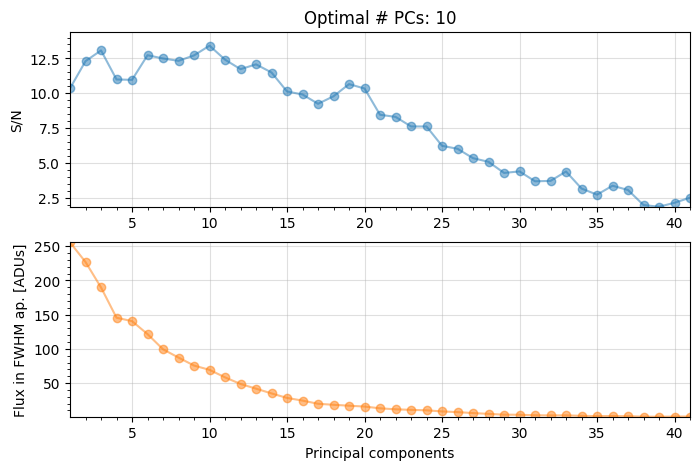

In [14]:
res_ann_opt = pca_grid(cubefc, angs, fwhm=fwhm_naco, range_pcs=(1,41,1), source_xy=xy_test, mode='annular',
                       annulus_width=4*fwhm_naco, imlib=imlib_rot, interpolation=interpolation, 
                       full_output=True, plot=True)

The grid search looking for the optimal number of principal components (npc) found that 10 principal components maximizes the S/N ratio of the injected fake companion. 

In [15]:
_, final_ann_opt, _, opt_npc_ann = res_ann_opt

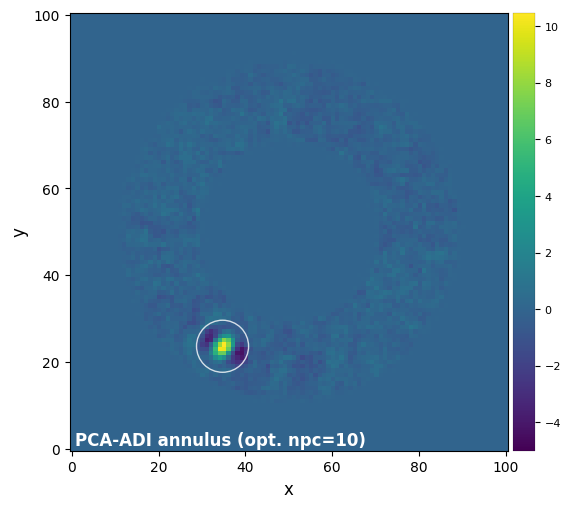

In [16]:
plot_frames(final_ann_opt, label='PCA-ADI annulus (opt. npc={:.0f})'.format(opt_npc_ann),
            dpi=100, vmin=-5, colorbar=True, circle=xy_test)

We can see that the fake companion was indeed injected at the requested location.

## 5.3. Flux and position estimation with NEGFC

When a companion candidate is detected, the next step is to characterize it, i.e. infer its exact position (astrometry) and flux (photometry). 

<font color=orange> **Question 5.1**: Why would a simple 2D Gaussian fit (as performed e.g. for the stellar PSF in Section 5.1) be inappropriate to extract the astrometry and photometry of a candidate companion? </font>

`VIP` implements the Negative fake companion (NEGFC) technique for robust extraction of the position and flux of detected point-like sources. The technique can be summarized as follow (see full description in [Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract)):

1) Estimate the position and flux of the planet, from either the visual inspection of reduced images or a previous estimator (see ABC below).

2) Scale (in flux) and shift the normalized off-axis PSF to remove the estimate from the input data cube.

3) Process the cube with PCA in a single annulus encompassing the point source.

4) Measure residuals in an aperture centered on the approximate location of the companion candidate.

5) Iterate on the position and flux of the injected negative PSF (steps 2-4), until the absolute residuals in the aperture are minimized (i.e. the injected negative companion flux and the position match exactly that of the true companion).

Iterations between steps 2-4 can be performed in one of 3 ways - sorted in increasing computation time and accuracy: 

A) a grid search on the flux only, provided a fixed estimate of the position (implemented in the `firstguess` function);

B) a Nelder-Mead simplex algorithm (`firstguess` function with the `simplex=True` option);

C) an MCMC sampler, which has the advantage to also yield uncertainties on each of the parameters of the point source (`mcmc_negfc_sampling` function).

Different figures of merit can be used for minimization of the residuals ([Wertz et al. 2017](https://ui.adsabs.harvard.edu/abs/2017A%26A...598A..83W/abstract); [Christiaens et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.6117C/abstract)):
$$\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}~~({\rm default}), ~~~~~~~~\chi^2 = \sum_j^N |I_j|, ~~~~~~~~\chi^2 = N {\rm std}(I_j).$$

where $j \in {1,...,N}$, $N$ is the total number of pixels contained in the circular aperture around the companion candidate, $\mu$ and $\sigma$ are the mean and standard deviation ($N_{\rm resel}$ degrees of freedom) of pixel intensities in a truncated annulus at the radius of the companion candidate, but avoiding the azimuthal region encompassing the negative side lobes.

### 5.3.1. Nelder-Mead based optimization

With the function `firstguess`, we can obtain a first estimation of the flux and position by running A) a naive grid minimization (grid of values for the flux through parameter `f_range`), and B) a Nelder-mead based minimization (if the parameter `simplex` is set to *True*). The latter is done based on the preliminary guess of the grid minimization. The maximum number of iterations and error can be set with the parameter `simplex_options` as a dicitionary (see `scipy.minimize` function for the Nelder-Mead options).

Fisrt we define the position of the sources by examining a flux frame or S/N map. `planets_xy_coord` takes a list or array of X,Y pairs like ((x1,y1),(x2,y2)...(x_n,y_n)). Let's take the coordinates of the previously injected companion.

Let's test the algorithm with different values for the # of PCs: 5 and 25.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 01:21:49
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   1.933
2/30   0.149   1.933
3/30   0.221   1.932
4/30   0.329   1.931
5/30   0.489   1.930
6/30   0.728   1.927
7/30   1.083   1.924
8/30   1.610   1.919
9/30   2.395   1.912
10/30   3.562   1.901
11/30   5.298   1.886
12/30   7.880   1.862
13/30   11.721   1.827
14/30   17.433   1.776
15/30   25.929   1.698
16/30   38.566   1.581
17/30   57.362   1.416
18/30   85.317   1.191
19/30   126.896   0.907
20/30   188.739   0.543
21/30   280.722   0.175
22/30   417.532   0.043


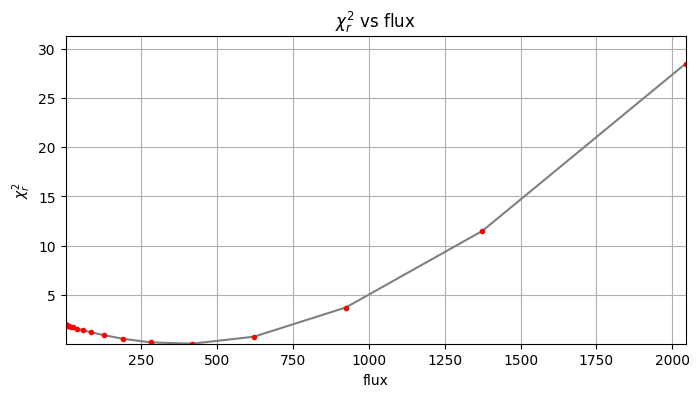

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.5
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 88, nfev: 208, chi2r: 0.027626969432102817
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.547, 239.971, 384.840) at 
          (X,Y)=(34.71, 23.55)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:01:15.364625
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [17]:
r_lo, theta_lo, f_lo = firstguess(cubefc, angs, psfn, ncomp=5, planets_xy_coord=[xy_test], 
                                  fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                  aperture_radius=2, simplex=True, imlib=imlib_rot, 
                                  interpolation=interpolation, plot=True, verbose=True)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 01:23:05
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   0.322
2/30   0.149   0.322
3/30   0.221   0.322
4/30   0.329   0.322
5/30   0.489   0.322
6/30   0.728   0.322
7/30   1.083   0.322
8/30   1.610   0.322
9/30   2.395   0.322
10/30   3.562   0.322
11/30   5.298   0.321
12/30   7.880   0.320
13/30   11.721   0.319
14/30   17.433   0.317
15/30   25.929   0.313
16/30   38.566   0.310
17/30   57.362   0.301
18/30   85.317   0.272
19/30   126.896   0.244
20/30   188.739   0.197
21/30   280.722   0.117
22/30   417.532   0.064


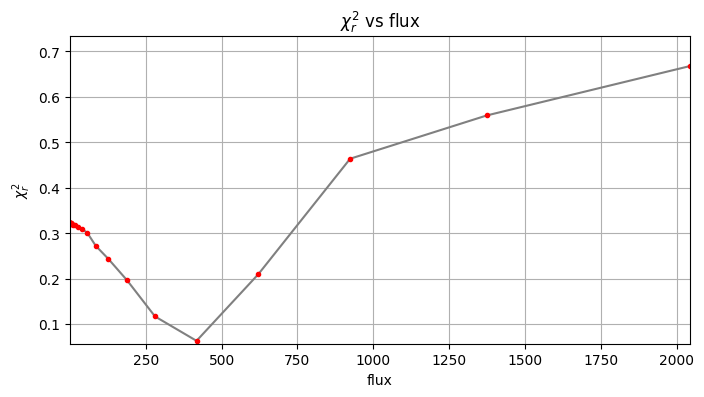

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.5
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 58, nfev: 168, chi2r: 0.05751191932736462
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.186, 239.897, 424.143) at 
          (X,Y)=(34.86, 23.89)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:49.105108
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [18]:
r_hi, theta_hi, f_hi = firstguess(cubefc, angs, psfn, ncomp=25, planets_xy_coord=[xy_test], 
                                  fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                                  aperture_radius=2, imlib=imlib_rot, interpolation=interpolation, 
                                  simplex=True, plot=True, verbose=True)

For both the $n_{\rm pc} = 5$ and $n_{\rm pc} = 25$ cases, the parameters estimated by the Nelder-Mead optimization are not exactly equal to the original values (radius=30.5, theta=240, flux=400), which reflects:

- the limitations of this heuristic minization procedure (depending on the initial guess the minimization may get trapped in a different local minimum);
- the higher residual speckle noise level in images obtained with low $n_{\rm pc}$ values; 
- the higher self-subtraction for high $n_{\rm pc}$ values.

These estimates are provided without uncertainties (error bars). We will come back to this question later on. 

For comparison, let's use the optimal $n_{\rm pc} = 10$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets):

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 01:23:54
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [34.749999999999986,23.58622518457463], running ...
Step | flux    | chi2r
1/30   0.100   1.951
2/30   0.149   1.951
3/30   0.221   1.950
4/30   0.329   1.950
5/30   0.489   1.948
6/30   0.728   1.946
7/30   1.083   1.944
8/30   1.610   1.939
9/30   2.395   1.933
10/30   3.562   1.924
11/30   5.298   1.911
12/30   7.880   1.891
13/30   11.721   1.861
14/30   17.433   1.818
15/30   25.929   1.749
16/30   38.566   1.661
17/30   57.362   1.523
18/30   85.317   1.288
19/30   126.896   1.010
20/30   188.739   0.637
21/30   280.722   0.218
22/30   417.532   0.052


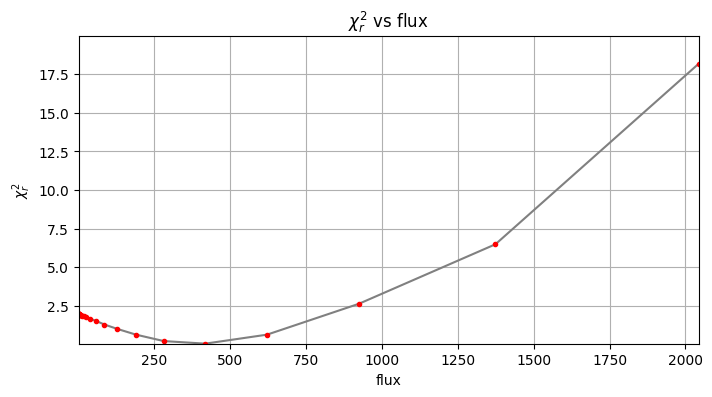

Planet 0: preliminary position guess: (r, theta)=(30.5, 240.0)
Planet 0: preliminary flux guess: 417.5
Planet 0: Simplex Nelder-Mead minimization, running ...
Planet 0: Success: True, nit: 68, nfev: 165, chi2r: 0.04395945745570059
message: Optimization terminated successfully.
Planet 0: simplex result: (r, theta, f)=(30.534, 239.933, 390.873) at 
          (X,Y)=(34.70, 23.57)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:26.698135
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [19]:
r_0, theta_0, f_0 = firstguess(cubefc, angs, psfn, ncomp=opt_npc_ann, planets_xy_coord=[xy_test], 
                               fwhm=fwhm_naco, f_range=None, annulus_width=4*fwhm_naco, 
                               aperture_radius=2, imlib=imlib_rot, interpolation=interpolation, 
                               simplex=True, plot=True, verbose=True)

We see that using the optimal $n_{\rm pc}$ leads to a closer parameter estimates to the ground truth.

<font color=green> **Answer 5.1**: If relying on a 2D Gaussian fit, both the photometry and astrometry would be biased by self-subtraction and the negative side lobes. </font>

### 5.3.2. Planet subtraction

Let's use the values obtained with the simplex optimization to subtract the planet with the function `cube_planet_free`.

First we define a list with the parameters (r, theta, flux) is each companion that we obtained via the NegFC, in this case one:

In [20]:
plpar_fc = [(r_0[0], theta_0[0], f_0[0])]

Note: r_0, theta_0 and f_0 have the same length as the number of planet coordinates `planets_xy_coord` provided to `firstguess`. Here there is only one planet, so we take the zeroth index. The number of tuples in (i.e the length of) `plpar_fc` should match the number of planets.

In [21]:
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)

Let's double-check the fake companion was well removed by computing a PCA post-processed image:

In [22]:
from vip_hci.preproc import cube_derotate
from vip_hci.config import time_ini, timing
t0 = time_ini()
for i in range(100):
    fr_pca_emp = pca_annulus(cube_emp, angs, ncomp=opt_npc_ann, annulus_width=4*fwhm_naco, 
                             r_guess=rad_fc, imlib=imlib_rot, interpolation=interpolation)
    #cube_tmp = cube_derotate(cube_emp, angs, imlib=imlib_rot, interpolation=interpolation, edge_blend='')
timing(t0)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 01:24:20
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:11.764804
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Let's take a look at the PSF of the planet in the full-frame PCA final image and the same PSF in the frame resulting of processing the planet-subtracted cube:

In [23]:
cropped_frame1 = frame_crop(final_ann_opt, cenxy=xy_test, size=15)

New shape: (15, 15)


In [24]:
cropped_frame2 = frame_crop(fr_pca_emp, cenxy=xy_test, size=15)

New shape: (15, 15)


Let's use both `'mode=surface'` and the default image mode of `plot_frames` to show the residuals in the vicinity of the companion:

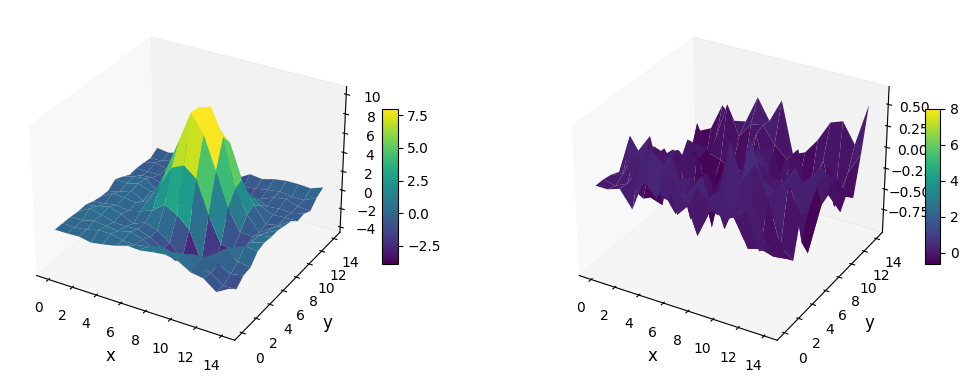

In [25]:
plot_frames((cropped_frame1, cropped_frame2), mode='surface', vmax=8)

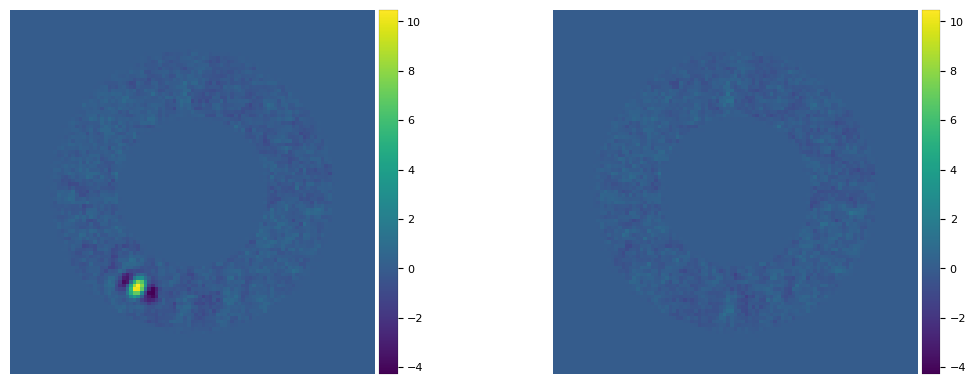

In [26]:
plot_frames((final_ann_opt, fr_pca_emp), vmin = float(np.amin(final_ann_opt)), 
            vmax= float(np.amax(final_ann_opt)), axis=False)

Not only the bright point-like signal is subtracted, but so are the negative side lobes. A subtraction not leaving any significant artifact/defect is a good sign that the inferred parameters are correct. However, keep in mind that even for slightly inaccurate parameters, the final image can still look relatively clean. Let's take for example the parameters inferred with non-optimal $n_{\rm pc}$: 

[(30.547288438104047, 239.9708851445477, 384.8400913238594)]


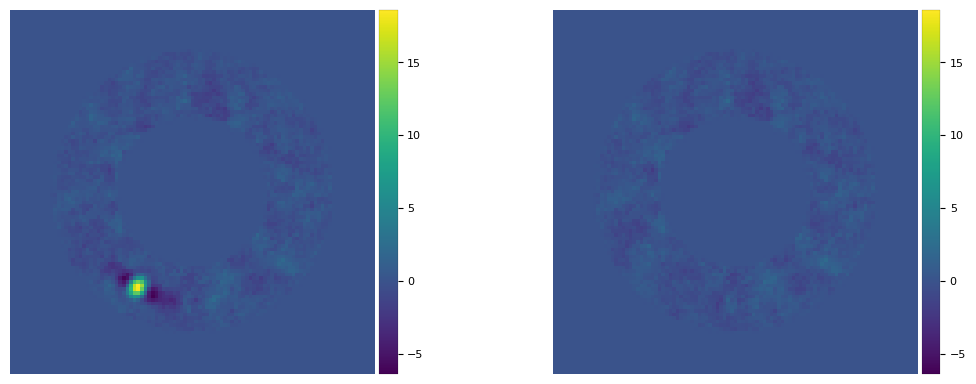

In [27]:
# planet parameters inferred from npc=5 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_lo[0], theta_lo[0], f_lo[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)
final_ann_5 = pca_annulus(cubefc, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp5 = pca_annulus(cube_emp, angs, ncomp=5, annulus_width=4*fwhm_naco, r_guess=30.5,
                                  imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_5, fr_pca_emp5), vmin = float(np.amin(final_ann_5)), 
            vmax= float(np.amax(final_ann_5)), axis=False)

[(30.185654487910202, 239.89660151207698, 424.14272218644646)]


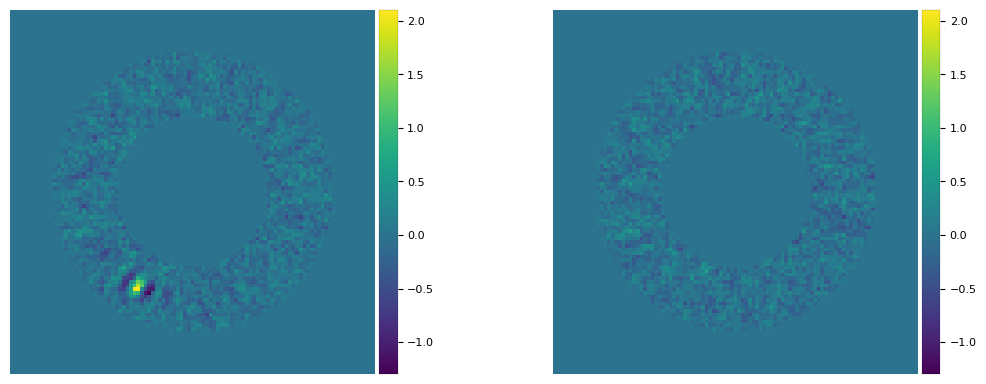

In [28]:
# parameters inferred from npc=25 used to make empty cube, then processed with PCA (npc=10)
plpar_fc = [(r_hi[0], theta_hi[0], f_hi[0])]
print(plpar_fc)
cube_emp = cube_planet_free(plpar_fc, cubefc, angs, psfn, imlib=imlib_rot, interpolation=interpolation)
final_ann_25 = pca_annulus(cubefc, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
fr_pca_emp25 = pca_annulus(cube_emp, angs, ncomp=25, annulus_width=4*fwhm_naco, r_guess=30.5,
                                   imlib=imlib_rot, interpolation=interpolation)
plot_frames((final_ann_25, fr_pca_emp25), vmin = float(np.amin(final_ann_25)), 
            vmax= float(np.amax(final_ann_25)), axis=False)

Inaccurate parameters still leading to an apparently good removal of the companion brings the question of the uncertainties on each of the three parameters characterizing the companion. The next sections are dedicated to this question. 

### 5.3.3. NEGFC technique coupled with MCMC

#### 5.3.3.1. Running the MCMC sampler

MCMC is a more robust way of obtaining the flux and position. It samples the posterior distributions of the parameters and from them we can infer both the most likely parameter values and uncertainties on each parameter. The relevant function is `mcmc_negfc_sampling`, which can accept a number of parameters. Let's define them in the next few boxes:

Let's first define observation-related parameters, such as the non-coronagraphic psf, its FWHM and the pixel scale od the detector: 

In [29]:
obs_params = {'psfn': psfn,
              'fwhm': fwhm_naco}

In NEGFC, PCA in a single annulus is used by default to speed up the algorithm - although other algorithms can be used through the `algo` parameter. Let's set the $n_{\rm pc}$ to the optimal $n_{\rm pc}$ found in [Section 5.2](#5.2.-Generating-and-injecting-synthetic-planets). We set the width of the annulus on which PCA is performed (in pixels) with the `annulus_width` parameter. We also set a few other algorithm-related parameters in the following box:

In [30]:
annulus_width = 4*fwhm_naco

algo_params = {'algo': pca_annulus,
               'ncomp': opt_npc_ann,
               'annulus_width': annulus_width,
               'svd_mode': 'lapack',
               'imlib': imlib_rot, 
               'interpolation': interpolation}

The choice of log-likelihood expression to be used is determined by `mu_sigma` and `fm`. If the former is True (default; mu and sigma calculated automatically) or a tuple of 2 values, the following figure of merit will be used: $\chi^2 = \sum_j^N \frac{(I_j-\mu)^2}{\sigma^2}$. Otherwise, the choice will be determined by `fm`: 'sum' for the sum of absolute residuals, or 'stddev' for the standard deviation of residuals (which can be useful if the point source is contained within a more extended signal).
`aperture_radius` is the radius of the aperture  (in `fwhm` units) in which the residual intensities $I_j$ are considered.

In [31]:
mu_sigma=True
aperture_radius=2

negfc_params = {'mu_sigma': mu_sigma,
                'aperture_radius': aperture_radius}

Parameter ``initial_state`` corresponds to the initial first estimation of the planets parameters (r, theta, flux). We set it to the result of the simplex optimization, obtained with optimal $n_{\rm pc}$. Note that the MCMC minimization can only run for one companion candidate at a time, hence the first dimension of init should always be 3 (not the number of planets, as opposed to `planets_xy_coord` in `firstguess`).

In [32]:
initial_state = np.array([r_0[0], theta_0[0], f_0[0]])

Beware that the MCMC procedure is a CPU intensive procedure and can take several hours when run properly on a standard laptop. We use the affine invariant sampler from `emcee` which can be run in parallel (`nproc` sets the number of CPUs to be used). At least 100 walkers are recommended for our MCMC chain, although both the number of walkers and iterations will depend on your dataset. 
For the sake of preventing this tutorial to take too long to run, we set the maximum number of iterations to 500, although feel free to significantly increase it in case of non-convergence.

In [33]:
from multiprocessing import cpu_count

nwalkers, itermin, itermax = (100, 200, 500)

mcmc_params = {'nwalkers': nwalkers,
               'niteration_min': itermin,
               'niteration_limit': itermax,
               'bounds': None,
               'nproc': cpu_count()//2}


Another update from Christiaens et al. (2021) is that the convergence can now be evaluated based on the auto-correlation time (see more details in the [documentation of `emcee`](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/)), instead of the Gelman-Rubin test, which is inappropriate for non-independent samples (such as an MCMC chain).
We set the convergence test to the autocorrelation time based criterion using `conv_test='ac'` (instead of Gelman-Rubin 'gb'). We also set the autocorrelation criterion $N/\tau >= a_c$, where $N$ is the number of samples and $\tau$ the autocorrelation time, to `ac_c=50` (the value recommended in the `emcee` documentation). Finally, we set the number of consecutive times the criterion must be met to: `ac_count_thr=1`, and the maximum gap in number of steps between 2 checks of the convergence criterion to: `check_maxgap=50`. If the maximum number of iterations `niteration_limit` is large enough, the chain will stop upon meeting the convergence criterion (spoiler: it won't be the case here since we chose a small value for `niteration_limit`).

In [34]:
conv_test, ac_c, ac_count_thr, check_maxgap = ('ac', 50, 1, 50)

conv_params = {'conv_test': conv_test,
               'ac_c': ac_c,
               'ac_count_thr': ac_count_thr,
               'check_maxgap': check_maxgap}

Setting `bounds=None` does *not* mean no bounds are used for parameter exploration, but rather that they are set automatically to:

- $r \in [r_0-w_{ann}/2, r_0+w_{ann}/2]$, where $w_{ann}$ is the `annulus_width`,
- $\theta \in [\theta_0-\Delta {\rm rot}, \theta_0+\Delta {\rm rot}]$, where $\Delta {\rm rot}$ is the angle subtended by min(`aperture_radius`/2,`fwhm`) at $r_0$,
- $f \in [0.1*f_0, 2*f_0]$,

where ($r_0, \theta_0, f_0$) = `initial_state`.
If the `bounds` are provided manually (as a tuple of tuples), they will supersede the automatic setting above.

Now let's start the sampler. Note that this step is computer intensive and may take a long time to run depending on your machine. Feel free to skip the next box if you do not wish to run the MCMC or can't run it in a reasonable time. The results are already saved as 'MCMC_results' in the 'datasets' folder and will be loaded in the subsequent boxes.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 01:24:33
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
        MCMC sampler for the NEGFC technique       
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
The mean and stddev in the annulus at the radius of the companion (excluding the PA area directly adjacent to it) are -0.05 and 1.50 respectively.
Beginning emcee Ensemble sampler...
emcee Ensemble sampler successful

Start of the MCMC run ...
Step  |  Duration/step (sec)  |  Remaining Estimated Time (sec)
0		3.34020			1666.76205
1		2.19021			1090.72508
2		2.19359			1090.21224
3		2.31976			1150.59898
4		2.69719			1335.11152
5		2.51392			1241.87450
6		2.24456			1106.56561
7		2.41634			1188.83928
8		2.23449			1097.13704
9		2.26186			1108.31140
10		2.21542			1083.33940
11		2.50433			1222.11304
12		2.53846			1236.23051
13		2.31661			1125.87246
14		2.24655			1089.579

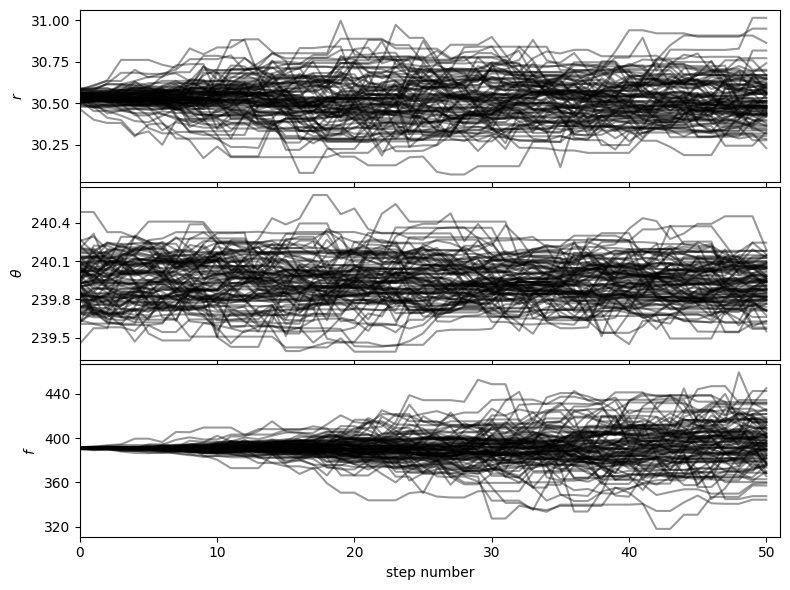

51		2.54530			1140.29306
52		2.08067			930.05815
53		2.11232			942.09561
54		2.09718			933.24688
55		2.17275			964.70011
56		2.10914			934.34681
57		2.15011			950.34685
58		2.17226			957.96886
59		2.18168			959.94008
60		2.11695			929.34149
61		2.46803			1080.99626
62		2.35530			1029.26523
63		2.09239			912.28030
64		2.23483			972.15236
65		2.36501			1026.41304
66		2.59780			1124.84567
67		2.21290			955.97366
68		2.15923			930.62942
69		2.15128			925.04825
70		2.18316			936.57693
71		2.12676			910.25114
72		2.11734			904.10375
73		2.07810			885.26975
74		2.16641			920.72382
75		2.11242			895.66820
76		2.13628			903.64686
77		2.16101			911.94749
78		2.15495			907.23395
79		2.08001			873.60420
80		2.12340			889.70669
81		2.09617			876.19906
82		2.21262			922.66212
83		2.14954			894.20989
84		2.15548			894.52379
85		2.23857			926.76674
86		2.08401			860.69613
87		2.08148			857.57017
88		2.07639			853.39752
89		2.14784			880.61604
90		2.13956			875.08045
91		2.09796			855.96890
92		2.06908

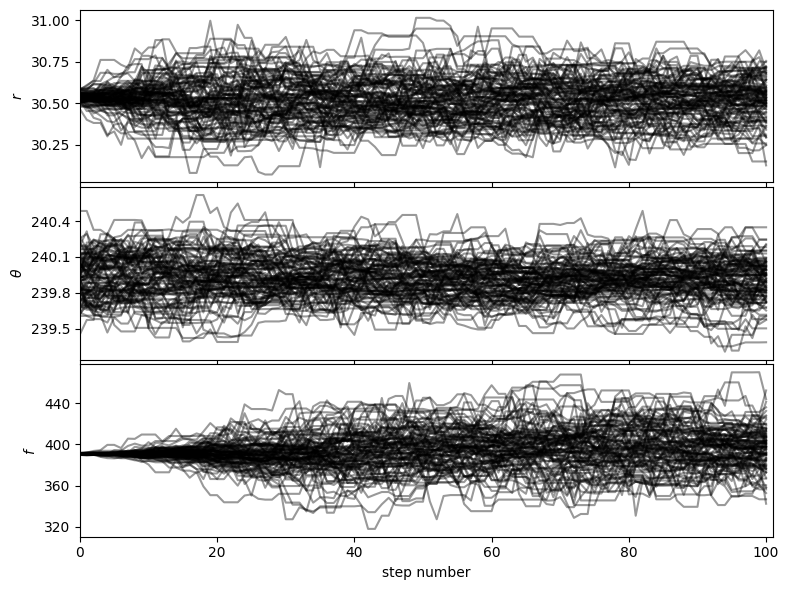

101		2.69116			1071.08128
102		2.05989			817.77633
103		2.07748			822.68406
104		2.23612			883.26701
105		2.10922			831.03110
106		2.06535			811.68412
107		2.05835			806.87438
108		2.06989			809.32855
109		2.04803			798.73053
110		2.08677			811.75159
111		2.05931			799.01267
112		2.10048			812.88692
113		2.07984			802.81785
114		2.06703			795.80616
115		2.04899			786.81370
116		2.06094			789.33964
117		2.04725			782.04874
118		2.04670			779.79156
119		2.06307			783.96546
120		2.06342			782.03580
121		2.04304			772.27063
122		2.06675			779.16287
123		2.05629			773.16654
124		2.07103			776.63475
125		2.05197			767.43678
126		2.05511			766.55715
127		2.06125			766.78649
128		2.08546			773.70492
129		2.16224			800.03065
130		2.12664			784.73090
131		2.07121			762.20381
132		2.09308			768.15999
133		2.14571			785.33023
134		2.10268			767.47674
135		2.14343			780.20961
136		2.17731			790.36353
137		2.14328			775.86808
138		2.06101			744.02641
139		2.15655			776.35980
140		2.08707			749.25921

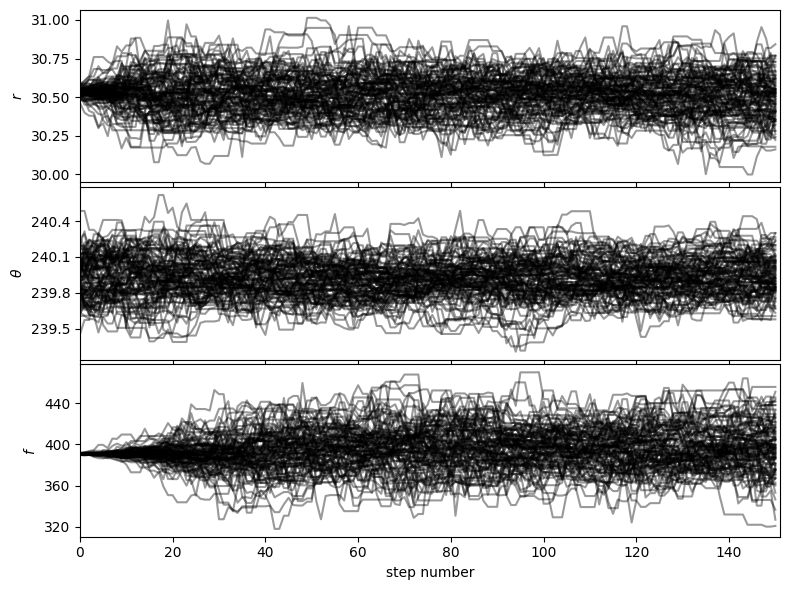

151		2.61897			911.39982
152		2.37419			823.84462
153		2.83107			979.55160
154		2.17449			750.19974
155		2.09674			721.27925
156		2.19557			753.08154
157		2.21266			756.72938
158		2.06697			704.83609
159		2.08820			709.98970
160		2.23117			756.36697
161		2.50535			846.80661
162		2.13338			718.94872
163		2.08458			700.41888
164		2.09756			702.68427
165		2.07810			694.08607
166		2.06960			689.17780
167		2.32841			773.03046
168		2.54923			843.79678
169		2.80098			924.32307
170		2.76579			909.94392
171		2.76688			907.53697
172		2.83906			928.37229
173		2.90796			947.99366
174		2.88044			936.14332
175		2.81847			913.18493
176		2.86848			926.51775
177		3.20779			1032.90709
178		2.80812			901.40524
179		2.51933			806.18624
180		2.78288			887.73936
181		2.83167			900.47138
182		2.81588			892.63491
183		2.94505			930.63580
184		2.90089			913.77940
185		2.87036			901.29430
186		2.81578			881.34070
187		2.76816			863.66467
188		3.04537			947.10883
189		2.89733			898.17199
190		2.89537			894.66840

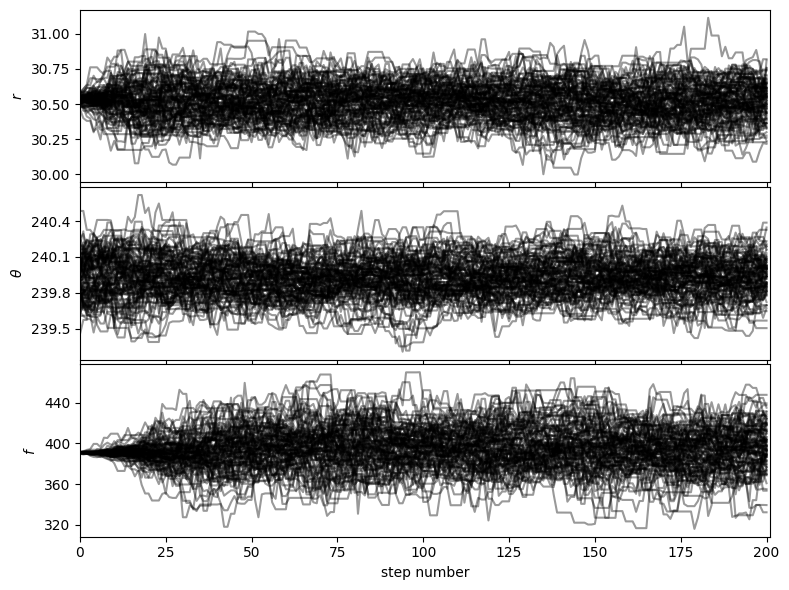

Auto-corr tau/N = [0.07087539 0.06974356 0.06146271]
tau/N <= 0.02 = [False False False] 

201		3.52743			1051.17414
202		2.73947			813.62318
203		2.63211			779.10545
204		2.64475			780.20007
205		2.79837			822.72196
206		2.70746			793.28695
207		2.65428			775.05093
208		2.75838			802.68829
209		2.84864			826.10676
210		2.53620			732.96296
211		2.60016			748.84522
212		2.48939			714.45378
213		2.63463			753.50275
214		2.72670			777.11007
215		2.70954			769.50822
216		2.87432			813.43228
217		2.77169			781.61545
218		2.58293			725.80249
219		2.64148			739.61552
220		2.64630			738.31686
221		2.74591			763.36242
222		2.65482			735.38514
223		2.73050			753.61690
224		2.91694			802.15740
225		2.72512			746.68425
226		2.74792			750.18298
227		2.63281			716.12568
228		2.71890			736.82109
229		2.74596			741.40866
230		2.62960			707.36186
231		2.85010			763.82707
232		2.97704			794.86861
233		2.95865			787.00090
234		2.89675			767.63875
235		2.89458			764.16833
236		2.98838			785.94315
237		2.9

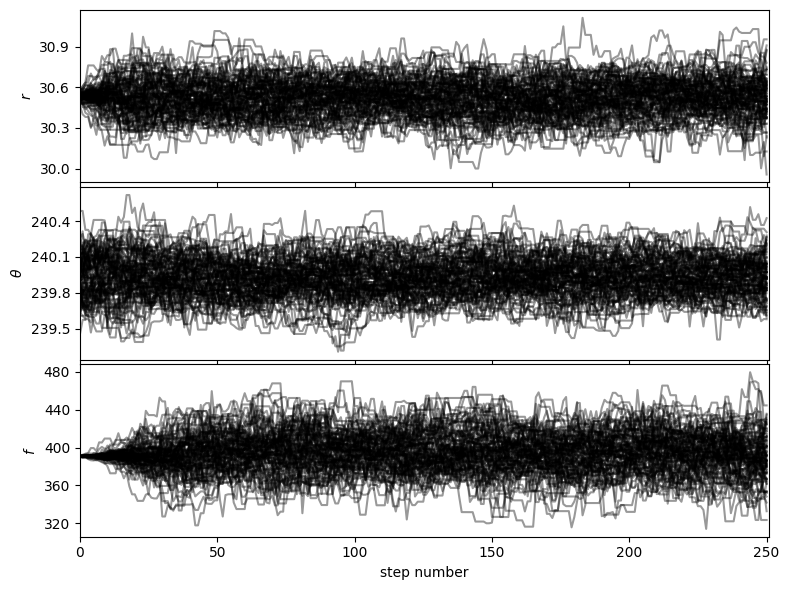

Auto-corr tau/N = [0.06574988 0.06474131 0.06063177]
tau/N <= 0.02 = [False False False] 

251		3.47166			860.97094
252		3.09527			764.53095
253		3.02699			744.64003
254		2.99275			733.22277
255		2.91808			712.01201
256		2.90441			705.77114
257		2.81173			680.43914
258		3.02314			728.57794
259		2.88697			692.87232
260		2.92427			698.90053
261		2.89583			689.20873
262		2.78900			660.99395
263		2.82519			666.74508
264		2.63651			619.57867
265		2.58678			605.30722
266		2.53243			590.05666
267		2.70067			626.55474
268		2.72029			628.38745
269		2.73645			629.38327
270		2.70971			620.52359
271		2.73447			623.45848
272		2.52986			574.27731
273		2.71623			613.86708
274		2.46491			554.60587
275		2.50596			561.33482
276		2.40330			535.93657
277		2.54190			564.30136
278		2.54490			562.42246
279		2.66556			586.42386
280		2.77727			608.22213
281		2.75815			601.27692
282		2.62267			569.11982
283		2.74276			592.43638
284		2.62823			565.06924
285		2.81274			601.92636
286		2.76452			588.84233
287		2.76

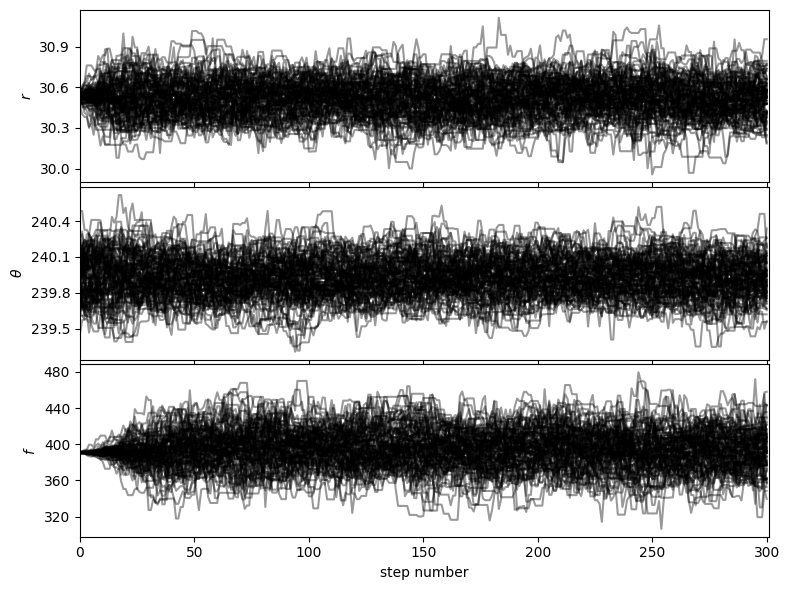

Auto-corr tau/N = [0.05992968 0.05819945 0.05582293]
tau/N <= 0.02 = [False False False] 

301		3.67342			727.33756
302		2.76478			544.66068
303		2.69858			528.92109
304		2.61604			510.12799
305		2.52045			488.96769
306		2.52258			486.85736
307		2.50870			481.67040
308		2.53884			484.91806
309		2.66045			505.48455
310		2.53255			478.65157
311		2.76081			519.03266
312		2.76065			516.24211
313		2.76599			514.47340
314		2.84052			525.49694
315		2.74399			504.89490
316		2.76381			505.77650
317		2.84358			517.53083
318		3.05685			553.28985
319		2.81842			507.31488
320		2.83538			507.53230
321		2.76428			492.04237
322		2.79499			494.71270
323		2.68584			472.70749
324		2.76566			483.99050
325		2.77391			482.65947
326		2.72442			471.32535
327		2.73903			471.11402
328		2.90955			497.53322
329		2.76018			469.23111
330		2.72374			460.31189
331		2.85692			479.96239
332		2.71598			453.56816
333		2.79313			463.65991
334		2.70836			446.87874
335		2.75596			451.97810
336		2.76465			450.63876
337		2.73

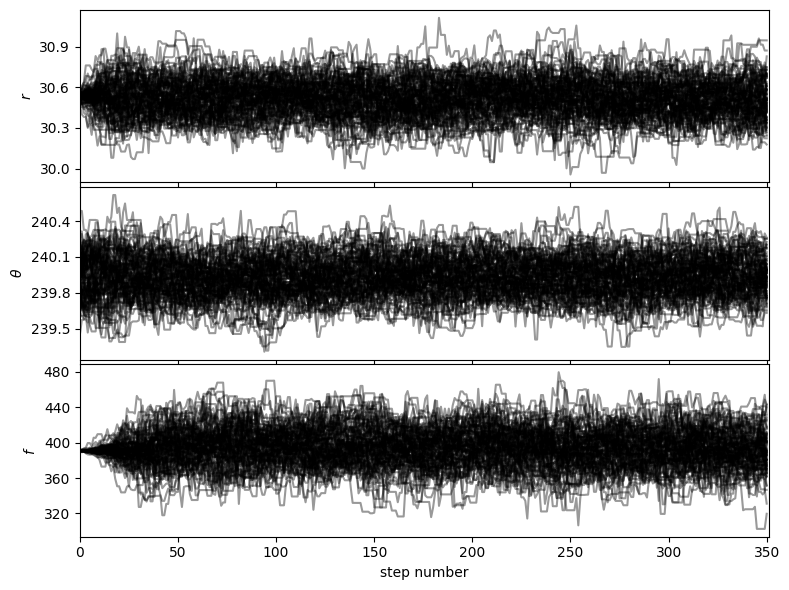

Auto-corr tau/N = [0.05508451 0.05191419 0.05251266]
tau/N <= 0.02 = [False False False] 

351		3.43288			508.06624
352		2.73257			401.68764
353		2.58356			377.20034
354		2.51574			364.78172
355		2.51717			362.47219
356		2.62229			374.98761
357		2.40624			341.68594
358		2.54885			359.38757
359		2.54833			356.76550
360		2.50697			348.46911
361		2.56279			353.66530
362		2.72524			373.35829
363		2.65975			361.72614
364		2.75432			371.83333
365		2.58017			345.74265
366		2.60259			346.14420
367		2.42601			320.23319
368		2.45330			321.38243
369		2.40520			312.67561
370		2.41590			311.65149
371		2.41999			309.75923
372		2.38995			303.52352
373		2.43677			307.03315
374		2.40730			300.91275
375		2.56228			317.72297
376		2.59147			318.75118
377		2.57029			313.57575
378		2.51667			304.51755
379		2.65217			318.26016
380		2.54162			302.45254
381		2.64226			311.78633
382		2.47525			289.60390
383		2.42360			281.13748
384		2.41674			277.92487
385		2.43464			277.54885
386		2.68985			303.95350
387		2.53

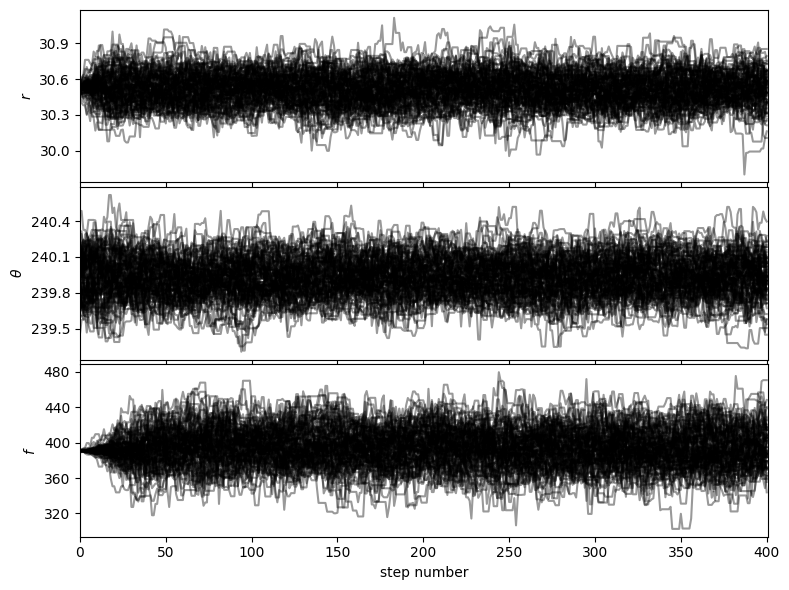

Auto-corr tau/N = [0.05289581 0.04833608 0.04925793]
tau/N <= 0.02 = [False False False] 

401		2.82485			276.83530
402		2.25909			219.13183
403		2.24930			215.93309
404		2.24570			213.34121
405		2.24639			211.16085
406		2.25156			209.39480
407		2.26234			208.13574
408		2.24111			203.94128
409		2.25257			202.73112
410		2.24761			200.03711
411		2.31194			203.45028
412		2.29979			200.08156
413		2.35230			202.29754
414		2.31974			197.17756
415		2.28121			191.62181
416		2.21409			183.76930
417		2.24480			184.07335
418		2.25174			182.39053
419		2.24899			179.91904
420		2.24385			177.26423
421		2.24402			175.03333
422		2.25827			173.88710
423		2.38987			181.63012
424		2.43192			182.39400
425		2.55201			188.84844
426		3.11255			227.21615
427		2.74537			197.66671
428		2.42016			171.83150
429		2.38266			166.78585
430		2.41526			166.65315
431		2.52072			171.40910
432		2.54994			170.84578
433		2.96115			195.43583
434		2.85865			185.81238
435		2.60083			166.45299
436		2.65571			167.30948
437		2.60

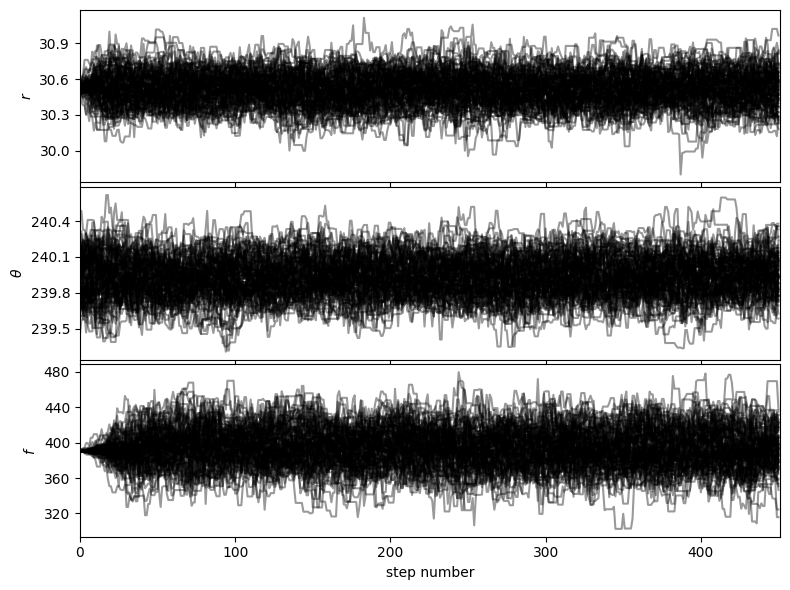

Auto-corr tau/N = [0.04968753 0.04632667 0.04714928]
tau/N <= 0.02 = [False False False] 

451		3.83669			184.16131
452		3.04320			143.03026
453		3.14967			144.88496
454		2.97998			134.09887
455		2.98020			131.12867
456		3.19212			137.26107
457		3.06396			128.68636
458		3.01083			123.44415
459		2.97735			119.09408
460		2.81378			109.73734
461		2.86901			109.02230
462		2.75484			101.92927
463		2.77912			100.04814
464		2.78004			97.30133
465		2.76424			93.98402
466		2.76505			91.24668
467		2.73225			87.43194
468		2.81760			87.34551
469		2.75159			82.54776
470		2.75168			79.79869
471		2.75524			77.14672
472		2.71894			73.41135
473		2.61586			68.01249
474		2.84165			71.04135
475		2.74670			65.92082
476		2.68962			61.86121
477		2.92619			64.37625
478		2.77344			58.24224
479		2.64283			52.85662
480		2.59341			49.27471
481		2.69371			48.48682
482		2.53827			43.15054
483		3.05704			48.91269
484		2.39190			35.87852
485		2.75769			38.60762
486		2.70853			35.21093
487		2.29752			27.57024
488		2.5

In [35]:
chain = mcmc_negfc_sampling(cubefc, angs, **obs_params, **algo_params, **negfc_params, 
                            initial_state=initial_state, **mcmc_params, **conv_params,
                            display=True, verbosity=2, save=False, output_dir='./')

If you ran the previous box and wish to write your results, set `write=True` in the next box. This will pickle the MCMC chain.

In [36]:
write=False

if write:
    import pickle
    output = {'chain':chain}
    with open('../datasets/my_MCMC_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

Note that an alternative to the box above, is to provide `output_dir` in the call to `mcmc_negfc_sampling` and set `save` to True. This will save the results as a pickle including additional keys: apart from 'chain', it will also save 'input_parameters', 'AR' (acceptance ratio), and 'lnprobability'.

Pickled results can be loaded from disk like this:

In [37]:
import pickle
with open('../datasets/MCMC_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    mcmc_result = myPickler.load()

print(mcmc_result.keys())
chain = mcmc_result['chain']

dict_keys(['chain', 'input_parameters', 'AR', 'lnprobability'])


The most accurate approach would involve setting a large enough maximum number of iterations and using FFT-based rotation for PCA. The latter in particular, may change a bit the most likely parameter values given the better flux conservation. However, these changes would involve over ~3 orders of magnitude longer calculation time. It is therefore intractable for a personal laptop and not shown in this notebook. If you have access to a supercomputer feel free to adopt these changes though. The results after 500 iterations are nonetheless good enough for illustrative purpose:

#### 5.3.3.2. Visualizing the MCMC chain: corner plots and walk plots 

Let's first check that the walk plots look ok:

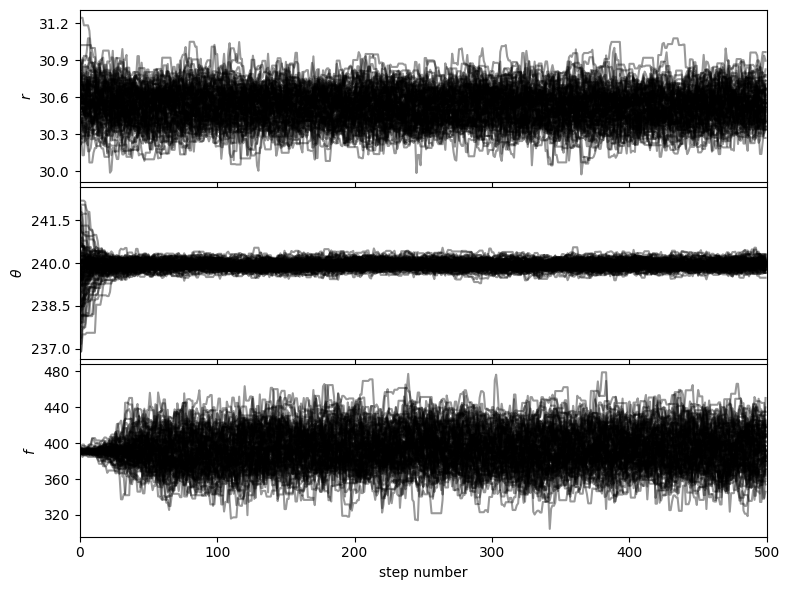

In [38]:
show_walk_plot(chain)

Then based on the walk plot, let's burn-in the first 30% of the chain, to calculate the corner plots:

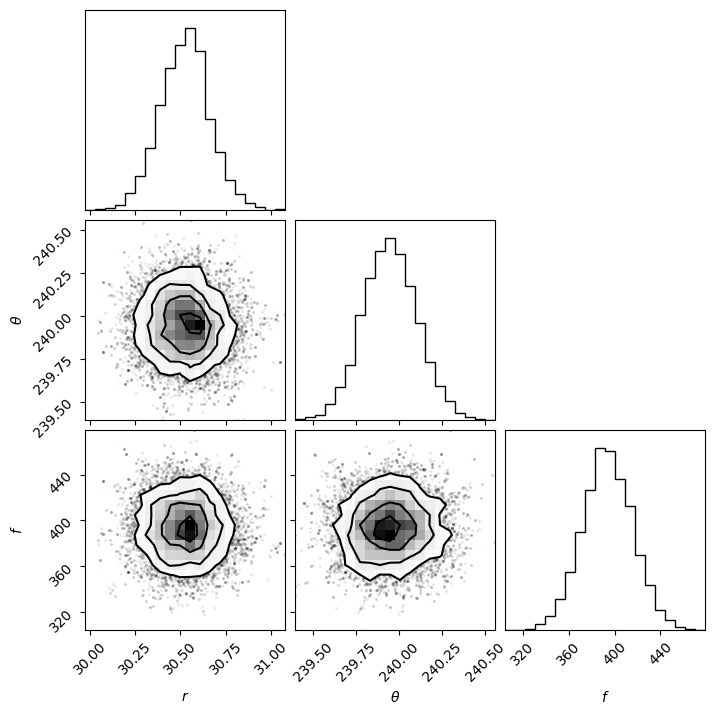

In [39]:
burnin = 0.3
burned_chain = chain[:, int(chain.shape[1]//(1/burnin)):, :]
show_corner_plot(burned_chain)

For the purpose of this tutorial and to limit computation time we set the maximum number of iterations to 500 for 100 walkers. The look of the corner plots may improve with more samples (i.e. higher number of iterations, for a given burn-in ratio). This can be tested by setting the max. number of iterations arbitrarily high for the autocorrelation-time convergence criterion to be met.

#### 5.3.3.3. Highly probable values and confidence intervals 

Now let's determine the most highly probable value for each model parameter, as well as the 1-sigma confidence interval. For this, let's first flatten the chains:

In [40]:
isamples_flat = chain[:, int(chain.shape[1]//(1/burnin)):, :].reshape((-1,3))

Then use the `confidence` function:

percentage for r: 69.79202279202278%
percentage for theta: 69.02279202279202%
percentage for f: 68.94017094017094%


/Users/valentin/GitHub/VIP/vip_hci/fm/negfc_mcmc.py:1541: UserWarning: The figure layout has changed to tight
  plt.tight_layout(w_pad=0.1)




Confidence intervals:
r: 30.57489764243517 [-0.20421878422770945,0.08279139901123145]
theta: 239.91771004343246 [-0.14527599962792692,0.18317408648738365]
f: 390.7650582608513 [-20.054061636888093,25.285555976945886]


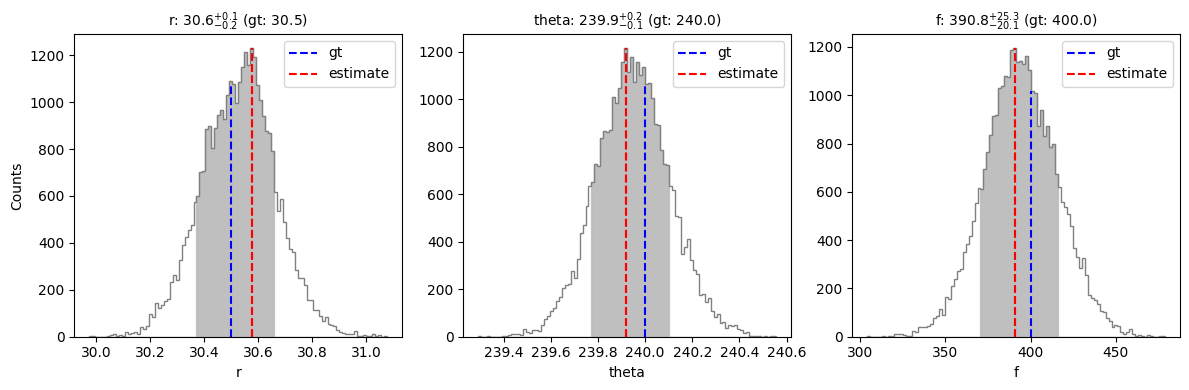

In [41]:
val_max, conf = confidence(isamples_flat, cfd=68, gaussian_fit=False, verbose=True, save=False, 
                           gt=gt, ndig=1, title=True)

Using the `confidence` function with the `gaussian_fit=True` option, it is possible to fit a Gaussian to the posterior distribution of each parameter, and infer associated uncertainty values.

percentage for r: 69.79202279202278%
percentage for theta: 69.02279202279202%
percentage for f: 68.94017094017094%


Confidence intervals:
r: 30.57489764243517 [-0.20421878422770945,0.08279139901123145]
theta: 239.91771004343246 [-0.14527599962792692,0.18317408648738365]
f: 390.7650582608513 [-20.054061636888093,25.285555976945886]

Gaussian fit results:
r: 30.525747462344565 +-0.13676103149725966
theta: 239.94793373875024 +-0.15744912409220196
f: 394.1338634773366 +-21.669634439677626


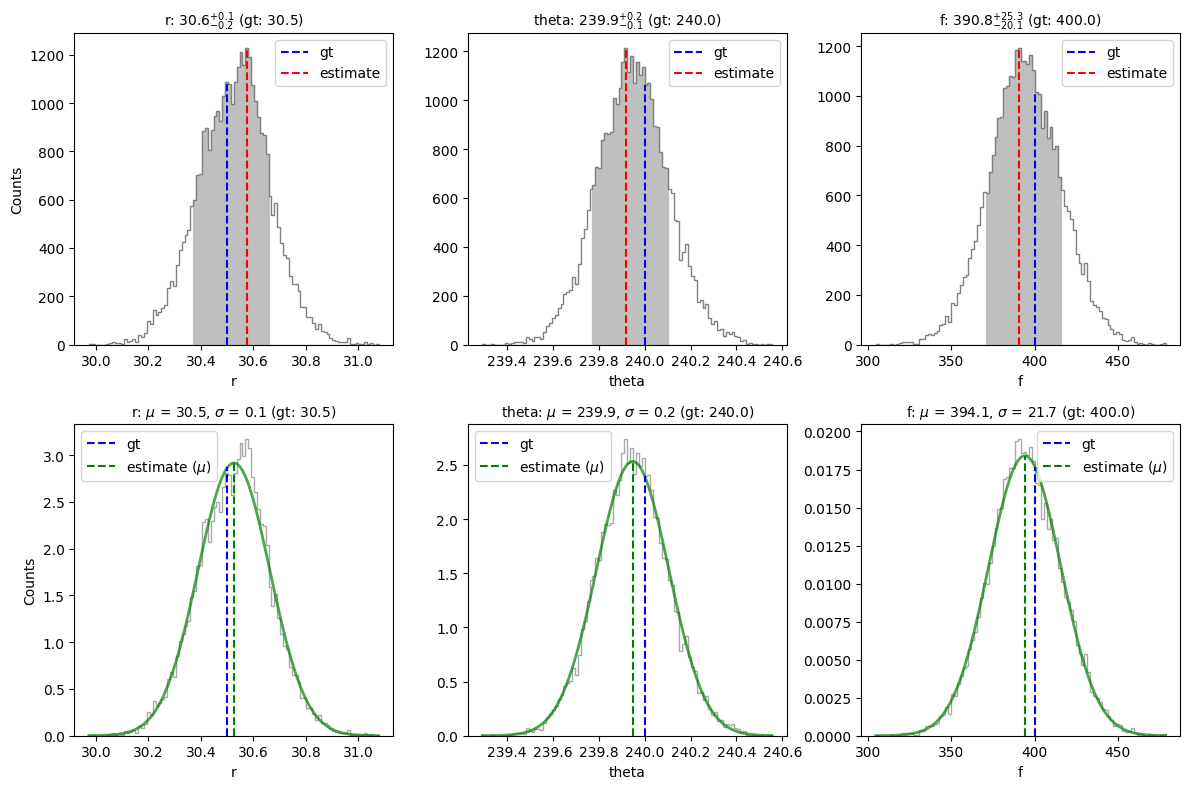

In [42]:
mu, sigma = confidence(isamples_flat, cfd=68, gaussian_fit=True, verbose=True, save=False, 
                       gt=gt, ndig=1, title=True)

It is recommended to report the results as confidence intervals (i.e. with possibly asymmetric uncertainties) as long as the bin interval is small enough. Here, we also fitted the residual posterior distribution of each parameter to a Gaussian distribution (this shape is the expected one if the noise has been well whitened, but is not necessarily guaranteed at all separations depending on the adopted $n_{\rm pc}$). In case, these distributions look Gaussian, the inferred $\sigma$ value may be a more accurate uncertainty value for the different parameters.

We can see that the confidence intervals inferred by NEGFC for the different parameters encompass the ground truth values used for injection (in particular for the flux). 

Note that depending on your choice of `mu_sigma`, you may have to calculate separately another source of uncertainty. Indeed, with the original expression for $\chi^2$ (Wertz et al. 2017; `mu_sigma=False`), only the uncertainty associated to *photon noise* was reflected in the MCMC results. With the new expression (`mu_sigma=True`), the $\chi^2$ expression also takes into account the *residual speckle noise* at the radial separation of the companion candidate. Our tests suggest that similar final uncertainties can be obtained in either of these 2 ways:  

- the uncertainties obtained with MCMC when setting `mu_sigma=True`;  
- the uncertainties obtained by combining quadratically the uncertainties obtained with MCMC (setting `mu_sigma=False` and `fm = 'sum'`), and the residual speckle uncertainties inferred as in [Sec. 5.3.4](#5.3.4.-Residual-speckle-uncertainty) (Wertz et al. 2017).  

### 5.3.4. Residual speckle uncertainty

**Only needed if using `mu_sigma=False` in your call to mcmc_negfc_sampling!**

Residual speckle noise can also bias the best parameter estimates found for the companion (if not taken into account in the MCMC).
To evaluate the uncertainty associated to this additional source of noise, it is recommended to inject a large number of fake companions at the same radius and flux as estimated for the true companion but different azimuths, and then estimate their parameters using simplex-NEGFC. The distribution of differences with respect to injected parameters can then give us an idea of the *residual speckle noise uncertainty*. This is done in VIP with the `speckle_noise_uncertainty` function (see also Sec. 3.3 in Wertz et al. 2017 for more details).

Let's use the planet parameters inferred by the MCMC-NEGFC algorithm:

In [43]:
pl_par = (val_max['r'],val_max['theta'],val_max['f'])
pl_par

(30.57489764243517, 239.91771004343246, 390.7650582608513)


#######################################################
###            SPECKLE NOISE DETERMINATION          ###
#######################################################

Number of steps: 360

Process is running for angle: 0.00
Process is running for angle: 18.00Process is running for angle: 36.00

Process is running for angle: 54.00
Process is running for angle: 72.00
Process is running for angle: 37.00
Process is running for angle: 1.00
Process is running for angle: 19.00
Process is running for angle: 55.00
Process is running for angle: 73.00
Process is running for angle: 38.00
Process is running for angle: 2.00
Process is running for angle: 20.00
Process is running for angle: 3.00
Process is running for angle: 56.00
Process is running for angle: 74.00
Process is running for angle: 39.00
Process is running for angle: 21.00
Process is running for angle: 4.00
Process is running for angle: 57.00
Process is running for angle: 75.00
Process is running for angle: 40.00
Process is running fo

Process is running for angle: 223.00
Process is running for angle: 207.00
Process is running for angle: 189.00
Process is running for angle: 259.00
Process is running for angle: 224.00
Process is running for angle: 241.00
Process is running for angle: 190.00
Process is running for angle: 208.00
Process is running for angle: 225.00
Process is running for angle: 260.00
Process is running for angle: 242.00
Process is running for angle: 191.00
Process is running for angle: 209.00
Process is running for angle: 243.00
Process is running for angle: 261.00
Process is running for angle: 226.00
Process is running for angle: 210.00
Process is running for angle: 244.00
Process is running for angle: 227.00
Process is running for angle: 192.00
Process is running for angle: 211.00
Process is running for angle: 262.00
Process is running for angle: 245.00
Process is running for angle: 193.00
Process is running for angle: 228.00
Process is running for angle: 263.00
Process is running for angle: 246.00
P



Confidence intervals:
r: -0.02412997296552928 [-0.056519922705534256,0.07912789178774797]
theta: 0.0014640689854274963 [-0.07307504175148613,0.07307504175148616]
f: -0.620744716053828 [-10.4942936707127,10.4942936707127]

Gaussian fit results:
r: -0.005358008112249547 +-0.05277034604807372
theta: -0.000828655169225096 +-0.07269053838995253
f: -0.05129156730094909 +-10.60503438051984


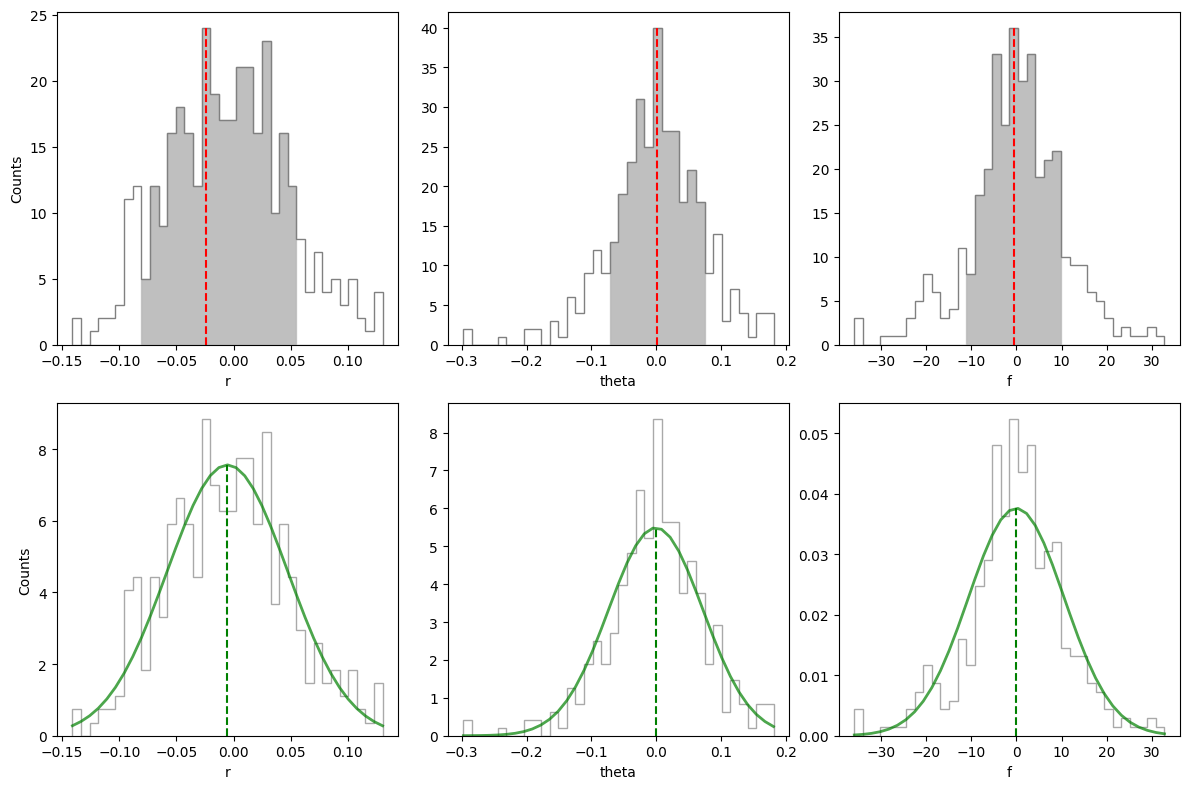

In [44]:
algo_options={'ncomp':opt_npc_ann, 'annulus_width':4*fwhm_naco, 'imlib':imlib_rot, 
              'interpolation':interpolation}
speckle_res = speckle_noise_uncertainty(cubefc, pl_par, np.linspace(0,359,360), angs, pca_annulus, 
                                        psfn, fwhm_naco, aperture_radius=2, fmerit='sum', 
                                        algo_options=algo_options, transmission=None, mu_sigma=None, 
                                        wedge=None, weights=None, force_rPA=False, nproc=None, 
                                        simplex_options=None, bins=None, save=False, output=None, 
                                        verbose=True, full_output=True, plot=True)

Again, if you wish to write the result (to avoid having to run the previous box again), just set `write=True`. This will pickle the result:

In [45]:
write=False

if write:
    output = {'speckle_res':speckle_res}
    with open('../datasets/my_speckle_residuals_results', 'wb') as fileSave:
        pickle.dump(output, fileSave)

Load pickled results from disk:

In [46]:
with open('../datasets/speckle_residuals_results','rb') as fi:
    myPickler = pickle.Unpickler(fi)
    sp_unc_result = myPickler.load()

print(sp_unc_result.keys())

speckle_res = sp_unc_result['speckle_res']
sp_unc, mean_dev, p_simplex, offset, chi2, nit, success = speckle_res

dict_keys(['speckle_res'])


The speckle uncertainty associated to each parameter is contained in `sp_unc` which corresponds to the 1$\sigma$ width of a Gaussian distribution fitted to the `offset` distribution (i.e. the differences with respect to injected ground truths):

In [47]:
sp_unc

array([ 0.05350939,  0.07376633, 10.64773837])

For comparison, the uncertainties found by the MCMC procedure were:

In [48]:
sigma

array([ 0.13676103,  0.15744912, 21.66963444])

### 5.3.5. Final uncertainties

The final uncertainties on the planet parameters should include both **statistical** and **systematic** uncertainties. 
The former include both the *photon noise* and *residual speckle noise* uncertainties discussed above. 
The latter include both the uncertainty on the *star location* (which may be non-negligible when using a coronagraph) and *instrumental calibration errors*, including:

- the uncertainty on the plate scale (for $r$, when converting to angular separation) - note that it is proportional to the radial separation itself;
- the uncertainty on the PA of true north (for $\theta$).

The uncertainty on the star location is of the order of 0.3px in individual NACO+AGPM images (this is the typical precision by manual recentering during the observation). Given the shift plots in `Tutorial 2`, it appears the autocorrelation timescale is of the order of ~5 frames. Therefore, considering that there are 61 frames in the datacube, the uncertainty on the star location in the final combined image must be roughly:

In [49]:
cen_unc_indiv = 0.3 #px
cen_unc = cen_unc_indiv/np.sqrt(61/5) #px
cen_unc

0.08588975014708022

The latter can be translated into an uncertainty on $\theta$ by division by the radial separation of the companion. The stellar centering uncertainties on each planet parameter can thus be expressed as:

In [50]:
star_unc = np.array([cen_unc*pxscale_naco, 
                     np.rad2deg(cen_unc/val_max['r']), 
                     0]) # uncertainty on each of the 3 parameters due to stellar centering

where the multiplication by `pxscale_naco` has converted the radial separation in arcsec.

For the instrumental calibration errors, we adopt the values quoted in Absil et al. (2013). Note that the uncertainty related to the plate scale is directly proportional to the radial separation of the companion.

In [51]:
dr_unc = 0.00004 # plate scale uncertainty in arcsec per px
tn_unc = 0.09    # deg
syst_unc = np.array([val_max['r']*dr_unc, 
                     tn_unc, 
                     0])

The final uncertainties are then the different sources of uncertainty added quadratically - after conversion of the radial separation to arcsec:

In [52]:
sigma[0] *= pxscale_naco
sp_unc[0] *= pxscale_naco

if mu_sigma:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(star_unc,2) + np.power(syst_unc,2))
else:
    final_unc = np.sqrt(np.power(sigma,2) + np.power(sp_unc,2) + np.power(star_unc,2) + np.power(syst_unc,2))

In [53]:
msg = "The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: \n"
msg+= "r = {:.2f}+-{:.2f} mas (GT: {:.2f} mas), \n"
msg+= "PA = {:.2f}+-{:.2f} deg (GT: {:.2f} deg) \n"
msg+= "f = {:.2f}+-{:.2f} ADUs (GT: {:.2f} ADUs)"
print(msg.format(val_max['r']*pxscale_naco*1000, final_unc[0]*1000, rad_fc*pxscale_naco*1000,
                 val_max['theta'], final_unc[1], theta_fc,
                 val_max['f'], final_unc[2], flux_fc))

The final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: 
r = 831.33+-4.56 mas (GT: 829.29 mas), 
PA = 239.92+-0.24 deg (GT: 240.00 deg) 
f = 390.77+-21.67 ADUs (GT: 400.00 ADUs)


Let's consider the Gaussian fit instead:

In [54]:
msg = "Considering a Gaussian fit to the posterior distributions, the final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: \n"
msg+= "r = {:.2f}+-{:.2f} mas (GT: {:.2f} mas), \n"
msg+= "PA = {:.2f}+-{:.2f} deg (GT: {:.2f} deg) \n"
msg+= "f = {:.2f}+-{:.2f} ADUs (GT: {:.2f} ADUs)"
print(msg.format(mu[0]*pxscale_naco*1000, final_unc[0]*1000, rad_fc*pxscale_naco*1000,
                 mu[1], final_unc[1], theta_fc,
                 mu[2], final_unc[2], flux_fc))

Considering a Gaussian fit to the posterior distributions, the final estimates on the radial separation, PA and flux of the companion, including uncertainties, are: 
r = 830.00+-4.56 mas (GT: 829.29 mas), 
PA = 239.95+-0.24 deg (GT: 240.00 deg) 
f = 394.13+-21.67 ADUs (GT: 400.00 ADUs)
